In [1]:
%matplotlib inline

# ставим пипом то, чего нет
# ! pip install numpy==1.17
# ! pip install scipy==1.1.0
# ! pip install scikit-learn==0.21.3
# ! pip install matplotlib
# ! pip install pandas
# ! pip install catboost

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from catboost import CatBoostRegressor
from scipy.spatial.distance import euclidean
from scipy.stats import norm, lognorm

In [2]:
data2017 = pd.read_csv("static/2017.csv")
data2018 = pd.read_csv("static/2018.csv")
data2019 = pd.read_csv("static/2019.csv")

In [ ]:
"""
ГИПОТЕЗЫ

1. Корреляции некоторых столбцов таблицы с целевым -> подтвердилось
2. Зависимость от географического положения -> подтвердилось
3. Природа распределения цены: нормальное -> не подтвердилось
4. Зависимость цены от даты продажи -> не подтвердилось
5. Зависимость цены от непараметрических признаков (новостройки и пр.) -> подтвердилось
6. Размер обучающих данных не сильно влияет на прогноз -> подтвердилось

ЧЁ СОБСНА ДЕЛАЕМ
1. Т.к. для обучения нужно не слишком много данных, то пропуски нужно просто дропать
2. Некоррелирующие столбцы модели просто не отдаем -> они её только сбивают
3. Надо посмотреть природу выбросов (хотя бы квартили) -> дропать нахер
4. Заменить широту и долготу на метрику удалённости от центра и использовать именно её
5. Заменить непараметрические фичи (в конце блокнота) на константы и отдать классификатору
6. С параметрами модели я уже наигрался -> нужно просто дать ей чистые данные
"""

In [28]:
data2017.head()

,transaction_id,created,duration,price,old_new,ppd_category,property_type,flat,floor_level,number_of_rooms,...,building_number,latitude,longitude,postcode_sector,closeststop,crimesin3km_antisocial,closestschool,closestpark,address_id,distance_center
0,{5CF9903C-EF46-7F13-E053-6C04A8C074B1},2017-06-22,F,86787,Y,B,T,NaN,NaN,NaN,...,24,53.177751,-1.191828,NG19 8,130.419369,741.0,735.0,674.0,102877980,3.658300
1,{5F54B81D-F9BF-2B45-E053-6B04A8C01FB0},2017-10-13,F,805000,N,A,D,NaN,NaN,9.0,...,3,51.380891,-1.605473,SN8 3,446.805795,10.0,633.0,NaN,97804281,27.205352
2,{4C4EE000-1146-1854-E050-A8C063054F34},2017-03-08,F,275000,N,A,D,NaN,NaN,NaN,...,36,52.469943,-2.134401,DY5 3,310.743404,1576.0,845.0,745.0,101429204,5.659612
3,{5F54B81D-EAA3-2B45-E053-6B04A8C01FB0},2017-10-27,L,220000,N,A,T,NaN,NaN,NaN,...,63,52.377534,-1.762286,B93 8,265.388640,184.0,817.0,686.0,100150188,4.190032
4,{5CF9903C-2479-7F13-E053-6C04A8C074B1},2017-05-05,F,237000,N,A,D,NaN,NaN,NaN,...,1,52.531956,-1.376669,LE10 2,236.354546,643.0,582.0,761.0,93361793,14.267637


In [21]:
# использовал это для продакшена
drop_columns = ['price']
train_columns = [
    'number_of_rooms', 'total_floor_area',
    'epc_lighting_cost_current', 'epc_heating_cost_current',
    'epc_number_open_fireplaces', 'latitude', 'longitude'
]
target = ['price']

data = data2018.dropna(subset=train_columns)
data2 = data2017.dropna(subset=train_columns)
print("Train size:", len(data))
print("Train size:", len(data2))

train_data = np.concatenate((data[train_columns], data2[train_columns]))
train_labels = np.concatenate((data[target], data2[target]))

eval_data = data2019[train_columns]
eval_labels = data2019[['transaction_id']]

print(eval_data.shape, eval_labels.shape)

Train size: 361281
Train size: 488811
(28323, 7) (28323, 1)


In [3]:
# тестил на этом
drop_columns = ['price']
train_columns = [
    'number_of_rooms', 'total_floor_area',
    'epc_lighting_cost_current', 'epc_heating_cost_current',
    'epc_number_open_fireplaces', 'latitude', 'longitude'
]
target = ['price']

data2 = data2018.dropna(subset=train_columns)
data = data2017.dropna(subset=train_columns)
# data2 = data2018
# data = data2017
print("Train size:", len(data))
print("Eval size:", len(data2))

train_data = data[train_columns]
train_labels = data[target]

eval_data = data2[train_columns]
eval_labels = data2[target]

Train size: 488811
Eval size: 361281


In [5]:
# (почти) дефолтный классификатор
# 
# MAE ~ круто
# Quantile ~ чуть хуже
# RMSE ~ терпимо
#
# другие дают говно результат

# примерно понял на какой стадии переобучается, поэтому параметры не случайны
model = CatBoostRegressor(learning_rate=0.5, depth=6, loss_function='MAE', 
                          iterations=None, silent=True) # можно настроить verbosity
model.fit(train_data, train_labels)

preds = model.predict(eval_data)
print("Score:", model.get_best_score())
print("Best iteration:", model.get_best_iteration())

# метрика (ЗАКОММЕНТИТЬ на данных для продакшена)
print("MdAPE:", np.median(abs(preds - eval_labels['price']) / preds))

Score: {'learn': {'MAE': 71834.79871467598}}
Best iteration: None
MdAPE: 0.161372516637438


In [7]:
print("Тестирование depth:")
for i in range(1, 10):
    model = CatBoostRegressor(learning_rate=1, depth=i, loss_function='Quantile', verbose=False)
    model.fit(train_data, train_labels)
    preds = model.predict(eval_data)

    print(i, np.median(abs(preds - eval_labels['price']) / preds))

Тестирование learning_rate:
[212387.69925788 161679.80826094  78052.84175399 ... 297462.89548972
 373656.88734343 122350.92698958]
1 0.24345404859112094
[172539.53761732 161664.51803672 102268.98553491 ... 285105.38986291
 264259.64795324  91340.8491447 ]
2 0.19405069295020752
[206364.55833011 164697.84982212  69328.0248193  ... 318388.22307308
 241121.38837114 129529.92665279]
3 0.1817605119676515
[221655.02712026 149718.47590936  74439.25872413 ... 316271.04979497
 215005.15888383 143664.77578442]
4 0.17537112538150695
[253497.3708117  133094.86973222  61560.19160973 ... 281406.30348188
 223274.46736619 146434.01807359]
5 0.17169906072512603
[207704.24778599 158026.97366208  57425.27173882 ... 301911.97718661
 248981.28800611 128016.8400262 ]
6 0.1693051680039298
[244427.45571227 142450.27211043  76561.61165293 ... 299708.63609629
 243487.29311146 124183.64233864]
7 0.16893567116865751
[227037.28278151 128494.16823647  50777.475581   ... 300093.80334756
 249089.53828503 160819.795376

In [8]:
print("Тестирование learning_rate:")
for i in range(1, 11):
    model = CatBoostRegressor(learning_rate=i/10, depth=6, loss_function='Quantile', verbose=False)
    model.fit(train_data, train_labels)

    preds = model.predict(eval_data)

    print(i/10, np.median(abs(preds - eval_labels['price']) / preds))

Тестирование learning_rate:
[196732.88518916 144087.90480538  80694.83012026 ... 296047.62659941
 226725.88031519 124467.37829796]
1 0.17400450102171675
[206408.67061721 137870.68138563  75584.08169368 ... 299164.54982763
 218901.89424626 123507.72804143]
2 0.16825745589493757
[207875.69852644 130784.84504359  64993.67012585 ... 313424.68026312
 208336.34717616 120903.79580296]
3 0.166180568899069
[215130.32006265 131765.63741484  64980.1692473  ... 296939.33585143
 239480.28183636 144134.8443949 ]
4 0.1653238288268244
[226981.97512532 129894.47390955  61860.88901662 ... 287388.97585755
 224837.42104037 131910.30250301]
5 0.16556825685915647
[220824.64204493 124762.85684798  68493.60901233 ... 299646.35053174
 220951.61366595 121344.85006737]
6 0.16643891355631302
[214963.6153657  133330.37453875  47966.36535836 ... 280066.21973048
 229911.93290477 124591.02729682]
7 0.16628941765560434
[234480.80523413 137803.39800927  62480.51881908 ... 293265.63677557
 258617.24119693 137373.4729010

In [20]:
# сохраняем в CSV вот так
df = pd.DataFrame.from_records({'transaction_id': eval_labels.values.reshape(eval_labels.values.shape[0], ), 
                                'price': preds.reshape(preds.shape[0], )}, index='transaction_id')
print(df.head())

df.to_csv('data.csv') 

In [47]:
# корреляционный анализ
#
# наблюдаем наличие слабой корреляции цены с колонками
# 'number_of_rooms rows', 'total_floor_area rows',
# 'epc_lighting_cost_current', 'epc_heating_cost_current',
# 'epc_number_open_fireplaces', 'crimesin3km_antisocial',
# 'epc_flat_storey_count'
#
# прочие колонки можем спокойно дропать

groups = data2018.columns.to_series().groupby(data2018.dtypes).groups
for key in groups:
    if key != np.sctypeDict["object"]:
        for col in groups[key]:            
            d = data2018.dropna(subset=[col])

            a = d['price']
            b = d[col]

            print(col, "rows:", len(d))
            print(np.corrcoef(a, b)[0, 1])
    

price rows: 986565
0.9999999999999999
address_id rows: 986565
0.029587567010435217
number_of_rooms rows: 361287
0.18757892792792807
total_floor_area rows: 409595
0.18907660767598156
epc_energy_consumption_current rows: 409595
0.018242073603866663
epc_lighting_cost_current rows: 409595
0.15769370373353553
epc_heating_cost_current rows: 409595
0.12487115299948241
epc_hot_water_cost_current rows: 409595
0.03227808858996808
epc_flat_storey_count rows: 39583
0.07526449718447296
epc_number_open_fireplaces rows: 362585
0.09972617947351622
epc_floor_height rows: 216794
0.020298414612969447
latitude rows: 906888
-0.05326185045657343
longitude rows: 906888
0.04579215021213316
closeststop rows: 896594
-0.0015546902471288144
crimesin3km_antisocial rows: 906668
0.08256380723283005
closestschool rows: 857402
0.013584648797665444
closestpark rows: 838429
-0.010433476112320584
distance_center rows: 906888
-0.017872673034673582


mean: 345382.0577569648
std: 1818852.1625287859


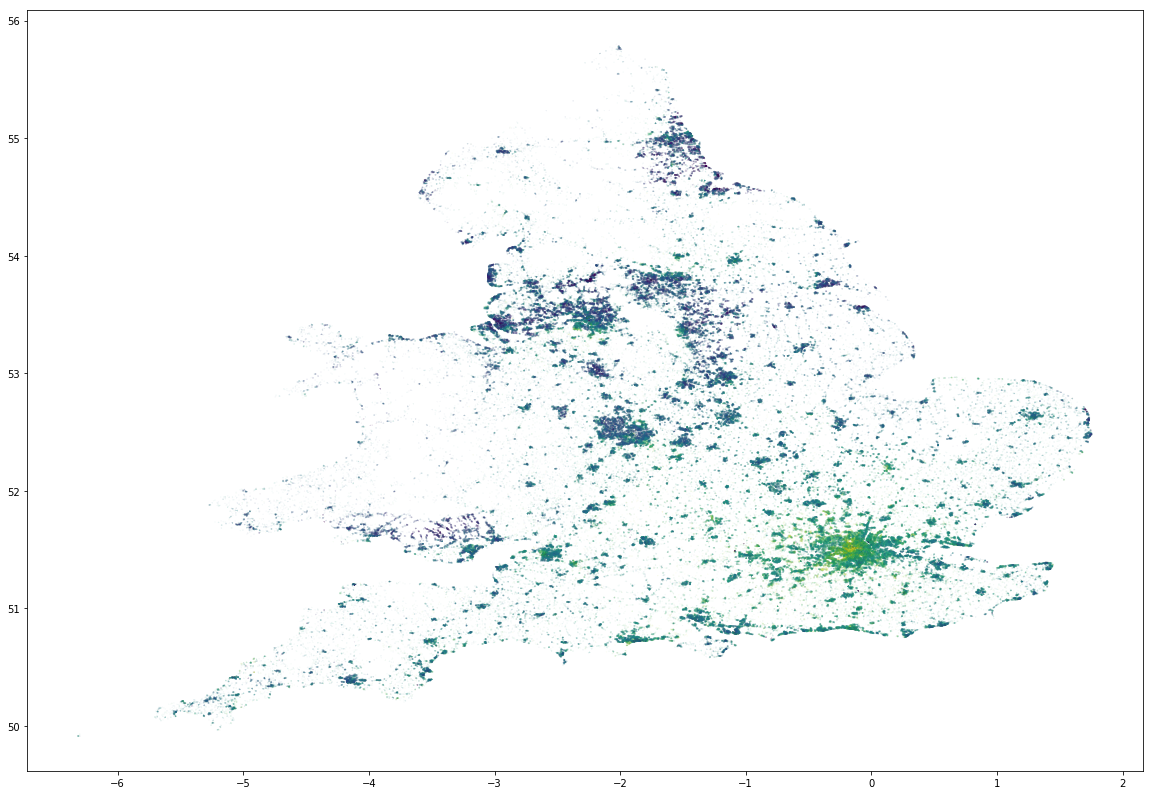

In [59]:
x = data2018['longitude'].values
y = data2018['latitude'].values
z = data2018['price'].values

mean = np.mean(z)
std = np.std(z)

print("mean:", mean)
print("std:", std)
  
colors = np.array(list(map(colorize, z)))

plt.scatter(x, y, c=colors, s=0.01, alpha=0.2, cmap='viridis')
plt.rcParams["figure.figsize"] = (20, 14)
plt.show()

# вывод: есть дорогие районы
# (приблизительно в окресности точки (-0.2, 51.5))
# значит, нужно ввести метрику удалённости от них

[0.2 0.8 0.5 ... 0.2 0.6 0.4]


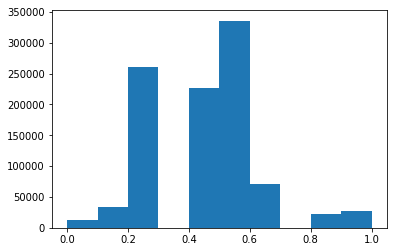

In [20]:
print(colors)
plt.hist(colors)
plt.show()
# вывод: распределение далеко от нормального
# + есть странный "провал" в ценовой категории

In [76]:
from datetime import datetime

def fix_date(elem):
    return (datetime.strptime(elem, "%Y-%m-%d")).timestamp()

data = data2017[["created", "price"]]
data = data.dropna()
dates = data["created"].values
prices = data["price"].values

datetimes = np.array(list(map(fix_date, dates)))
print(datetimes)

[1.4980644e+09 1.5078276e+09 1.4889060e+09 ... 1.4854500e+09 1.4836356e+09
 1.5072228e+09]


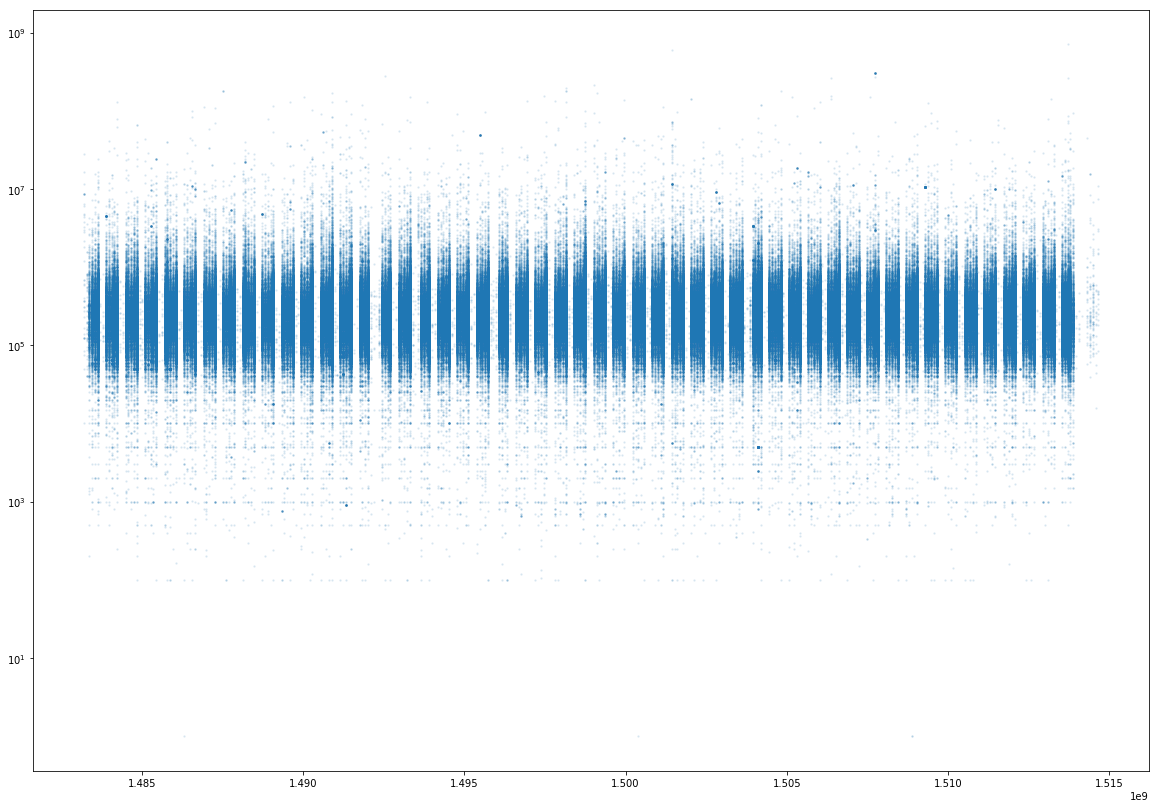

In [77]:
y = np.array(list(map(colorize, prices)))

plt.scatter(datetimes, prices, s=2, alpha=0.1)
plt.rcParams["figure.figsize"] = (20, 14)
plt.yscale('log')
plt.show()

# ну тут можно сказать только то, что в одни дни было больше продаж, чем в другие

In [ ]:
# дальше я тупо смотрю на непараметрические данные

In [78]:
new = data2017.loc[data2017['old_new'] == 'Y']
old = data2017.loc[data2017['old_new'] == 'N']

new_prices = new["price"].values
old_prices = old["price"].values

print("New prices mean:", np.mean(new_prices))
print("Old prices mean:", np.mean(old_prices))

print("New prices median:", np.median(new_prices))
print("Old prices median:", np.median(old_prices))

print("New prices std:", np.std(new_prices))
print("Old prices std:", np.std(old_prices))

# вывод: медианная цена старых построек и новостроек примерно равна
# но у старых зданий значительно выше дисперсия (что логично)
# следовательно, у новостроек в пропущенные данные можно попробовать ставить средние значения по выборке
# (потому что они примерно одинаковые в одних и тех же районах)

New prices mean: 336329.07739114517
Old prices mean: 343711.73949001456
New prices median: 274500.0
Old prices median: 218500.0
New prices std: 389710.472523107
Old prices std: 2157955.3332843794


In [6]:
f = data2018.loc[data2018['duration'] == 'F']
l = data2018.loc[data2018['duration'] == 'L']

f_prices = f["price"].values
l_prices = l["price"].values

print("F prices mean:", np.mean(f_prices))
print("L prices mean:", np.mean(l_prices))

print("F prices median:", np.median(f_prices))
print("L prices median:", np.median(l_prices))

print("F prices std:", np.std(f_prices))
print("L prices std:", np.std(l_prices))

# вывод: ну, в целом, тоже можно преобразовать в нули и единицы и отдать в классификатор
# тут видно, что L несколько дешевле
# не думаю, что это сильно ему поможет, но CatBoost явно умнее меня

F prices mean: 352297.6396393051
L prices mean: 322948.39979781903
F prices median: 240000.0
L prices median: 190000.0
F prices std: 1683151.804336195
L prices std: 2202079.7366599217


In [17]:
d = data2017.groupby(['property_type'])['property_type'].unique().values

for elem in d:
    print(elem)
    c = data2018.loc[data2018['property_type'] == elem[0]]
    
    prices = c["price"].values
    
    print("num:", len(prices))
    print("prices mean:", np.mean(prices))
    print("prices median:", np.median(prices))
    print("prices std:", np.std(prices))
    
# вывод: очень полезная фича для классификации цены

['D']
num: 228195
prices mean: 405253.40686255175
prices median: 330000.0
prices std: 351141.38456510875
['F']
num: 171224
prices mean: 301824.8172686072
prices median: 210999.5
prices std: 612591.4700220202
['O']
num: 55141
prices mean: 1203989.0660488566
prices median: 250000.0
prices std: 7436562.36620762
['S']
num: 261702
prices mean: 252984.8224889378
prices median: 205000.0
prices std: 217946.00776318414
['T']
num: 270303
prices mean: 236732.8554030107
prices median: 175000.0
prices std: 480099.7690725138
